# MLE и функции потерь в регрессии

## Введение

Maximum Likelihood Estimation (MLE) является теоретической основой для многих функций потерь в машинном обучении. В этом ноутбуке мы покажем, как **минимизация функций потерь эквивалентна максимизации правдоподобия** при определенных предположениях о распределении данных.

### Ключевая идея:

**Минимизация loss функции = Максимизация likelihood функции**

Разные предположения о распределении ошибок/целевой переменной приводят к разным loss функциям.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, log_loss

np.random.seed(42)

## 1. Линейная регрессия: от MLE к MSE

### Теория

**Предположение**: Ошибки распределены нормально

$$y_i = \beta_0 + \beta_1 x_i + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)$$

Это означает:
$$y_i | x_i \sim \mathcal{N}(\beta_0 + \beta_1 x_i, \sigma^2)$$

**Функция правдоподобия** (вероятность наблюдать данные при заданных параметрах):

$$L(\beta_0, \beta_1, \sigma^2 | X, y) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - (\beta_0 + \beta_1 x_i))^2}{2\sigma^2}\right)$$

**Логарифм правдоподобия** (проще для оптимизации):

$$\log L = -\frac{n}{2}\log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i - (\beta_0 + \beta_1 x_i))^2$$

**Максимизация** $\log L$ по $\beta_0, \beta_1$ **эквивалентна минимизации**:

$$\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 \quad \Rightarrow \quad \text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

### Вывод: MSE loss = MLE при нормально распределенных ошибках!

### Практический пример: Предсказание концентрации белка

In [2]:
# Генерируем данные: зависимость концентрации белка от времени
n = 100
X = np.random.uniform(0, 10, n)  # время (часы)
true_beta0 = 2.0   # начальная концентрация
true_beta1 = 3.0   # скорость роста
true_sigma = 2.0   # шум измерений

# y = истинная зависимость + гауссовский шум
y = true_beta0 + true_beta1 * X + np.random.normal(0, true_sigma, n)

print(f"Истинные параметры: β₀={true_beta0}, β₁={true_beta1}, σ={true_sigma}")
print(f"Размер выборки: n={n}")

Истинные параметры: β₀=2.0, β₁=3.0, σ=2.0
Размер выборки: n=100


### Метод 1: Максимизация Likelihood (MLE)

In [3]:
def negative_log_likelihood_linear(params, X, y):
    """
    Отрицательный логарифм правдоподобия для линейной регрессии
    с предположением о нормально распределенных ошибках
    """
    beta0, beta1, sigma = params
    
    if sigma <= 0:
        return np.inf
    
    # Предсказания модели
    predictions = beta0 + beta1 * X
    residuals = y - predictions
    
    # Negative log-likelihood
    n = len(y)
    nll = n/2 * np.log(2 * np.pi * sigma**2) + np.sum(residuals**2) / (2 * sigma**2)
    
    return nll

# Оптимизация: находим параметры, максимизирующие likelihood
initial_params = [0, 0, 1]
result_mle = minimize(
    negative_log_likelihood_linear, 
    initial_params, 
    args=(X, y), 
    method='L-BFGS-B',
    bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0.01, np.inf)]
)

beta0_mle, beta1_mle, sigma_mle = result_mle.x

print("\n=== MLE подход ===")
print(f"MLE оценки: β₀={beta0_mle:.3f}, β₁={beta1_mle:.3f}, σ={sigma_mle:.3f}")


=== MLE подход ===
MLE оценки: β₀=2.430, β₁=2.908, σ=1.796


### Метод 2: Минимизация MSE Loss

In [4]:
def mse_loss(params, X, y):
    """
    Mean Squared Error loss функция
    """
    beta0, beta1 = params
    predictions = beta0 + beta1 * X
    mse = np.mean((y - predictions)**2)
    return mse

# Оптимизация: находим параметры, минимизирующие MSE
initial_params_mse = [0, 0]
result_mse = minimize(
    mse_loss, 
    initial_params_mse, 
    args=(X, y), 
    method='L-BFGS-B'
)

beta0_mse, beta1_mse = result_mse.x

print("\n=== MSE подход ===")
print(f"MSE оценки: β₀={beta0_mse:.3f}, β₁={beta1_mse:.3f}")


=== MSE подход ===
MSE оценки: β₀=2.430, β₁=2.908


### Метод 3: sklearn LinearRegression (также минимизирует MSE)

In [5]:
# sklearn использует аналитическое решение (метод наименьших квадратов)
model_sklearn = LinearRegression()
model_sklearn.fit(X.reshape(-1, 1), y)

beta0_sklearn = model_sklearn.intercept_
beta1_sklearn = model_sklearn.coef_[0]

print("\n=== sklearn LinearRegression ===")
print(f"sklearn оценки: β₀={beta0_sklearn:.3f}, β₁={beta1_sklearn:.3f}")


=== sklearn LinearRegression ===
sklearn оценки: β₀=2.430, β₁=2.908


### Сравнение результатов

In [6]:
print("\n" + "="*60)
print("СРАВНЕНИЕ МЕТОДОВ")
print("="*60)
print(f"Истинные параметры:    β₀={true_beta0:.3f}, β₁={true_beta1:.3f}")
print(f"MLE (max likelihood):  β₀={beta0_mle:.3f}, β₁={beta1_mle:.3f}")
print(f"MSE (min loss):        β₀={beta0_mse:.3f}, β₁={beta1_mse:.3f}")
print(f"sklearn:               β₀={beta0_sklearn:.3f}, β₁={beta1_sklearn:.3f}")
print("\n✓ Все три метода дают практически одинаковые результаты!")
print("  Это подтверждает: минимизация MSE = максимизация likelihood")

# Вычисляем MSE для MLE решения
y_pred_mle = beta0_mle + beta1_mle * X
mse_value = np.mean((y - y_pred_mle)**2)
print(f"\nMSE для MLE решения: {mse_value:.3f}")


СРАВНЕНИЕ МЕТОДОВ
Истинные параметры:    β₀=2.000, β₁=3.000
MLE (max likelihood):  β₀=2.430, β₁=2.908
MSE (min loss):        β₀=2.430, β₁=2.908
sklearn:               β₀=2.430, β₁=2.908

✓ Все три метода дают практически одинаковые результаты!
  Это подтверждает: минимизация MSE = максимизация likelihood

MSE для MLE решения: 3.226


### Визуализация

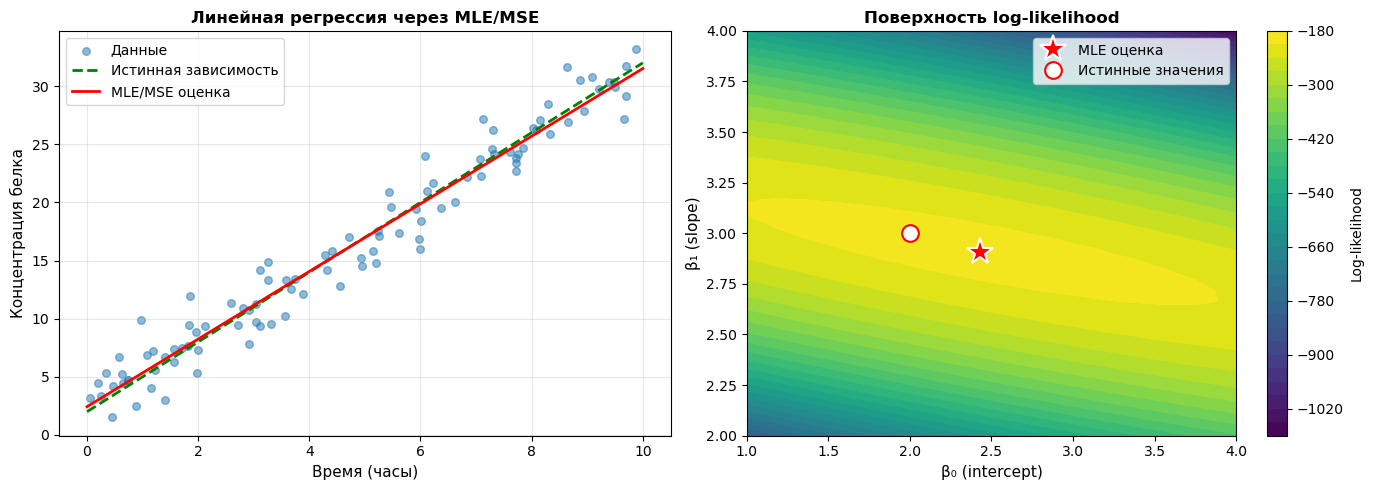

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Данные и предсказания
axes[0].scatter(X, y, alpha=0.5, s=30, label='Данные')
X_line = np.linspace(0, 10, 100)
axes[0].plot(X_line, true_beta0 + true_beta1 * X_line, 'g--', lw=2, label='Истинная зависимость')
axes[0].plot(X_line, beta0_mle + beta1_mle * X_line, 'r-', lw=2, label='MLE/MSE оценка')
axes[0].set_xlabel('Время (часы)', fontsize=11)
axes[0].set_ylabel('Концентрация белка', fontsize=11)
axes[0].set_title('Линейная регрессия через MLE/MSE', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Поверхность log-likelihood
beta0_range = np.linspace(1, 4, 40)
beta1_range = np.linspace(2, 4, 40)
B0, B1 = np.meshgrid(beta0_range, beta1_range)

LL = np.zeros_like(B0)
for i in range(len(beta0_range)):
    for j in range(len(beta1_range)):
        LL[j, i] = -negative_log_likelihood_linear([B0[j, i], B1[j, i], sigma_mle], X, y)

contour = axes[1].contourf(B0, B1, LL, levels=30, cmap='viridis')
axes[1].plot(beta0_mle, beta1_mle, 'r*', markersize=20, label='MLE оценка', markeredgecolor='white', markeredgewidth=1.5)
axes[1].plot(true_beta0, true_beta1, 'wo', markersize=12, label='Истинные значения', markeredgecolor='red', markeredgewidth=1.5)
axes[1].set_xlabel('β₀ (intercept)', fontsize=11)
axes[1].set_ylabel('β₁ (slope)', fontsize=11)
axes[1].set_title('Поверхность log-likelihood', fontsize=12, fontweight='bold')
axes[1].legend()
plt.colorbar(contour, ax=axes[1], label='Log-likelihood')

plt.tight_layout()
plt.show()

## 2. Логистическая регрессия: от MLE к Binary Cross-Entropy

### Теория

**Предположение**: Целевая переменная распределена по Бернулли (бинарная классификация)

$$y_i \sim \text{Bernoulli}(p_i)$$

где вероятность определяется сигмоидной функцией:

$$p_i = \sigma(\beta_0 + \beta_1 x_i) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_i)}}$$

**Функция правдоподобия** (для бинарных исходов $y_i \in \{0, 1\}$):

$$L(\beta_0, \beta_1 | X, y) = \prod_{i=1}^{n} p_i^{y_i}(1-p_i)^{1-y_i}$$

**Логарифм правдоподобия**:

$$\log L = \sum_{i=1}^{n} \left[y_i \log(p_i) + (1-y_i)\log(1-p_i)\right]$$

**Максимизация** $\log L$ **эквивалентна минимизации Binary Cross-Entropy (BCE)**:

$$\text{BCE} = -\frac{1}{n}\sum_{i=1}^{n}\left[y_i \log(\hat{p}_i) + (1-y_i)\log(1-\hat{p}_i)\right]$$

### Вывод: BCE loss = MLE при распределении Бернулли!

### Практический пример: Классификация больных/здоровых на основе биомаркера

In [8]:
# Генерируем данные: бинарная классификация
n = 200
X_log = np.random.uniform(-5, 5, n)  # уровень биомаркера
true_beta0_log = -1.0  # порог
true_beta1_log = 0.8   # чувствительность к биомаркеру

# Истинная вероятность заболевания
true_probs = 1 / (1 + np.exp(-(true_beta0_log + true_beta1_log * X_log)))

# Генерируем бинарные исходы (0 = здоров, 1 = болен)
y_log = np.random.binomial(1, true_probs)

print(f"Истинные параметры: β₀={true_beta0_log}, β₁={true_beta1_log}")
print(f"Размер выборки: n={n}")
print(f"Баланс классов: {np.sum(y_log==0)} здоровых, {np.sum(y_log==1)} больных")

Истинные параметры: β₀=-1.0, β₁=0.8
Размер выборки: n=200
Баланс классов: 123 здоровых, 77 больных


### Вспомогательные функции

In [9]:
def sigmoid(z):
    """Сигмоидная функция с защитой от переполнения"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

### Метод 1: Максимизация Likelihood (MLE)

In [10]:
def negative_log_likelihood_logistic(params, X, y):
    """
    Отрицательный логарифм правдоподобия для логистической регрессии
    с предположением о распределении Бернулли
    """
    beta0, beta1 = params
    
    # Вычисляем вероятности
    z = beta0 + beta1 * X
    probs = sigmoid(z)
    
    # Защита от log(0)
    epsilon = 1e-15
    probs = np.clip(probs, epsilon, 1 - epsilon)
    
    # Negative log-likelihood
    nll = -np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    
    return nll

# Оптимизация: находим параметры, максимизирующие likelihood
initial_params_log = [0, 0]
result_mle_log = minimize(
    negative_log_likelihood_logistic, 
    initial_params_log, 
    args=(X_log, y_log), 
    method='L-BFGS-B'
)

beta0_mle_log, beta1_mle_log = result_mle_log.x

print("\n=== MLE подход ===")
print(f"MLE оценки: β₀={beta0_mle_log:.3f}, β₁={beta1_mle_log:.3f}")


=== MLE подход ===
MLE оценки: β₀=-1.024, β₁=0.726


### Метод 2: Минимизация Binary Cross-Entropy Loss

In [11]:
def binary_cross_entropy_loss(params, X, y):
    """
    Binary Cross-Entropy loss функция
    """
    beta0, beta1 = params
    
    # Вычисляем вероятности
    z = beta0 + beta1 * X
    probs = sigmoid(z)
    
    # Защита от log(0)
    epsilon = 1e-15
    probs = np.clip(probs, epsilon, 1 - epsilon)
    
    # Binary Cross-Entropy
    bce = -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    
    return bce

# Оптимизация: находим параметры, минимизирующие BCE
result_bce_log = minimize(
    binary_cross_entropy_loss, 
    initial_params_log, 
    args=(X_log, y_log), 
    method='L-BFGS-B'
)

beta0_bce_log, beta1_bce_log = result_bce_log.x

print("\n=== BCE подход ===")
print(f"BCE оценки: β₀={beta0_bce_log:.3f}, β₁={beta1_bce_log:.3f}")


=== BCE подход ===
BCE оценки: β₀=-1.024, β₁=0.726


### Метод 3: sklearn LogisticRegression (также максимизирует likelihood/минимизирует BCE)

In [12]:
# sklearn использует численную оптимизацию
model_log_sklearn = LogisticRegression(penalty=None, solver='lbfgs')
model_log_sklearn.fit(X_log.reshape(-1, 1), y_log)

beta0_sklearn_log = model_log_sklearn.intercept_[0]
beta1_sklearn_log = model_log_sklearn.coef_[0][0]

print("\n=== sklearn LogisticRegression ===")
print(f"sklearn оценки: β₀={beta0_sklearn_log:.3f}, β₁={beta1_sklearn_log:.3f}")


=== sklearn LogisticRegression ===
sklearn оценки: β₀=-1.024, β₁=0.726


### Сравнение результатов

In [13]:
print("\n" + "="*60)
print("СРАВНЕНИЕ МЕТОДОВ")
print("="*60)
print(f"Истинные параметры:    β₀={true_beta0_log:.3f}, β₁={true_beta1_log:.3f}")
print(f"MLE (max likelihood):  β₀={beta0_mle_log:.3f}, β₁={beta1_mle_log:.3f}")
print(f"BCE (min loss):        β₀={beta0_bce_log:.3f}, β₁={beta1_bce_log:.3f}")
print(f"sklearn:               β₀={beta0_sklearn_log:.3f}, β₁={beta1_sklearn_log:.3f}")
print("\n✓ Все три метода дают практически одинаковые результаты!")
print("  Это подтверждает: минимизация BCE = максимизация likelihood")

# Вычисляем BCE для MLE решения
probs_mle = sigmoid(beta0_mle_log + beta1_mle_log * X_log)
bce_value = -np.mean(y_log * np.log(probs_mle + 1e-15) + (1 - y_log) * np.log(1 - probs_mle + 1e-15))
print(f"\nBCE для MLE решения: {bce_value:.4f}")


СРАВНЕНИЕ МЕТОДОВ
Истинные параметры:    β₀=-1.000, β₁=0.800
MLE (max likelihood):  β₀=-1.024, β₁=0.726
BCE (min loss):        β₀=-1.024, β₁=0.726
sklearn:               β₀=-1.024, β₁=0.726

✓ Все три метода дают практически одинаковые результаты!
  Это подтверждает: минимизация BCE = максимизация likelihood

BCE для MLE решения: 0.4072


### Визуализация

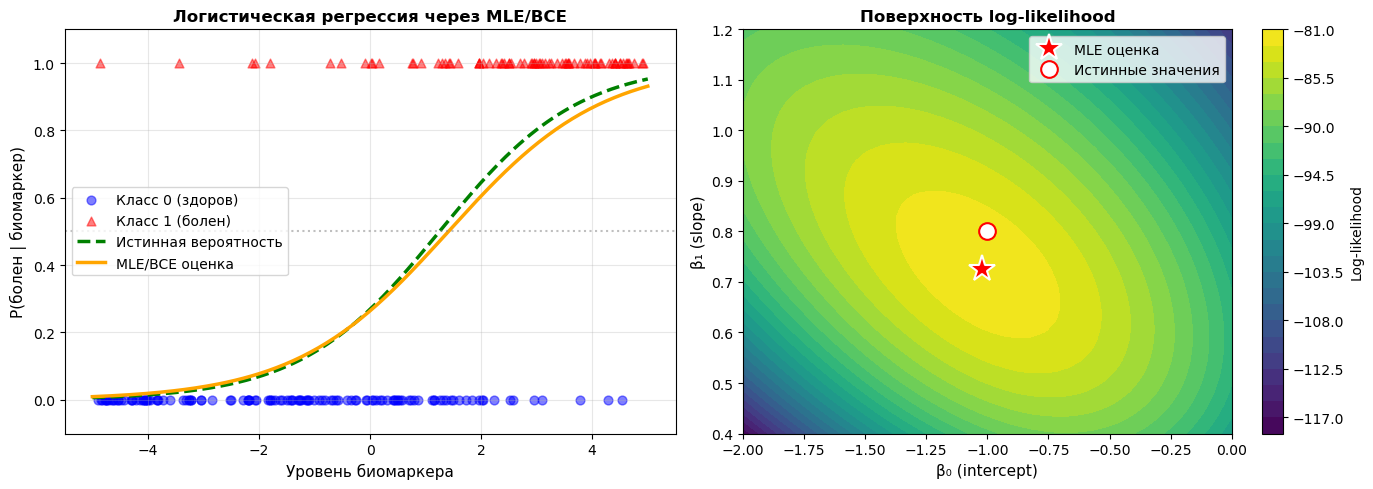

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Данные и вероятности
axes[0].scatter(X_log[y_log==0], y_log[y_log==0], alpha=0.5, s=40, label='Класс 0 (здоров)', color='blue', marker='o')
axes[0].scatter(X_log[y_log==1], y_log[y_log==1], alpha=0.5, s=40, label='Класс 1 (болен)', color='red', marker='^')

X_line_log = np.linspace(-5, 5, 200)
true_probs_line = sigmoid(true_beta0_log + true_beta1_log * X_line_log)
mle_probs_line = sigmoid(beta0_mle_log + beta1_mle_log * X_line_log)

axes[0].plot(X_line_log, true_probs_line, 'g--', lw=2.5, label='Истинная вероятность')
axes[0].plot(X_line_log, mle_probs_line, 'orange', lw=2.5, label='MLE/BCE оценка')
axes[0].axhline(0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Уровень биомаркера', fontsize=11)
axes[0].set_ylabel('P(болен | биомаркер)', fontsize=11)
axes[0].set_title('Логистическая регрессия через MLE/BCE', fontsize=12, fontweight='bold')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# График 2: Поверхность log-likelihood
beta0_range_log = np.linspace(-2, 0, 40)
beta1_range_log = np.linspace(0.4, 1.2, 40)
B0_log, B1_log = np.meshgrid(beta0_range_log, beta1_range_log)

LL_log = np.zeros_like(B0_log)
for i in range(len(beta0_range_log)):
    for j in range(len(beta1_range_log)):
        LL_log[j, i] = -negative_log_likelihood_logistic([B0_log[j, i], B1_log[j, i]], X_log, y_log)

contour_log = axes[1].contourf(B0_log, B1_log, LL_log, levels=30, cmap='viridis')
axes[1].plot(beta0_mle_log, beta1_mle_log, 'r*', markersize=20, label='MLE оценка', markeredgecolor='white', markeredgewidth=1.5)
axes[1].plot(true_beta0_log, true_beta1_log, 'wo', markersize=12, label='Истинные значения', markeredgecolor='red', markeredgewidth=1.5)
axes[1].set_xlabel('β₀ (intercept)', fontsize=11)
axes[1].set_ylabel('β₁ (slope)', fontsize=11)
axes[1].set_title('Поверхность log-likelihood', fontsize=12, fontweight='bold')
axes[1].legend()
plt.colorbar(contour_log, ax=axes[1], label='Log-likelihood')

plt.tight_layout()
plt.show()

## 3. Резюме

### Ключевые выводы:

| Тип регрессии | Предположение о распределении | Функция правдоподобия | Loss функция | Связь |
|--------------|------------------------------|----------------------|--------------|-------|
| **Линейная** | $\epsilon \sim \mathcal{N}(0, \sigma^2)$ | Произведение нормальных плотностей | **MSE** (Mean Squared Error) | max(likelihood) = min(MSE) |
| **Логистическая** | $y \sim \text{Bernoulli}(p)$ | Произведение вероятностей Бернулли | **BCE** (Binary Cross-Entropy) | max(likelihood) = min(BCE) |

### Общий принцип:

1. **Выбираем распределение** для ошибок/целевой переменной
2. **Записываем likelihood функцию** на основе этого распределения
3. **Максимизируем log-likelihood** (или минимизируем negative log-likelihood)
4. Получаем **loss функцию** для машинного обучения!

### Практическое значение:

- MLE дает **теоретическое обоснование** для выбора loss функций
- Разные предположения о данных → разные loss функции
- Понимание связи помогает выбирать правильные метрики и модели
- В биоинформатике это важно для моделирования экспрессии генов, классификации болезней и т.д.

### Другие примеры:

- **Пуассоновская регрессия** (для count data): предположение $y \sim \text{Poisson}(\lambda)$ → Poisson loss
- **Мультиклассовая классификация**: предположение $y \sim \text{Categorical}(p_1, ..., p_k)$ → Categorical Cross-Entropy
- **Робастная регрессия**: предположение о распределении Лапласа → MAE (Mean Absolute Error)

## 4. Задания для самостоятельной работы

1. **Сравните поведение MSE и MAE**: Создайте датасет с выбросами и сравните, как работают регрессии с MSE (предположение о нормальном распределении) и MAE (предположение о распределении Лапласа)

2. **Мультиклассовая классификация**: Расширьте пример логистической регрессии на случай 3+ классов. Покажите связь между максимизацией likelihood и минимизацией Categorical Cross-Entropy

3. **Пуассоновская регрессия**: Реализуйте регрессию для count data (например, количество мутаций). Используйте Пуассоновское распределение и выведите соответствующую loss функцию

4. **Эффект размера выборки**: Исследуйте, как размер выборки влияет на точность MLE оценок. Постройте графики для n = 20, 50, 100, 500, 1000